In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
# inline plotting
%matplotlib inline

In [3]:
from labproject.experiments import Experiment, ScaleDim, ScaleSampleSize
from labproject.utils import get_log_path
from labproject.plotting import generate_palette, color_dict

from labproject.data import DATASETS, DISTRIBUTIONS
from labproject.metrics import METRICS
from torch.distributions import MultivariateNormal

In [4]:
from labproject.data import DATASETS, DISTRIBUTIONS
from labproject.utils import get_cfg, set_seed, get_log_path
from labproject.data import get_dataset
import os
from omegaconf import OmegaConf
from labproject.experiments import *
from labproject.plotting import cm2inch
import time
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

In [5]:
"""dict = color_dict
print(f"Dict: {dict}")"""

"""col_map = {
    'ScaleSampleSize': 'XX',
    'ScaleSampleSizeKL': 'XX',
    'ScaleSampleSizeSW': 'wasserstein',
    'ScaleSampleSizeMMD': 'mmd',
    'ScaleSampleSizeC2ST': 'c2st',
    'ScaleDim': 'XX',
    'ScaleDimKL': 'XX',
    'ScaleDimSW': 'wasserstein',
    'ScaleDimMMD': 'mmd',
    'ScaleDimC2ST': 'c2st',
}"""

from labproject.plotting import generate_palette
color_dict = {"wasserstein": "#cc241d",
              "mmd": "#eebd35",
              "c2st": "#458588",
              "fid": "#8ec07c", 
              "kl": "#8ec07c"}


col_map = {'ScaleDimKL':'kl', 'ScaleDimSW':'wasserstein',
           'ScaleDimMMD':'mmd', 'ScaleDimC2ST':'c2st',
           'ScaleDimFID':'fid', }



In [6]:
METRICS.keys()


dict_keys(['mmd_rbf', 'mmd_rbf_auto', 'mmd_polynomial', 'mmd_linear_naive', 'mmd_linear', 'c2st_nn', 'c2st_rf', 'c2st_knn', 'gaussian_kl_divergence', 'wasserstein_gauss_squared', 'sliced_wasserstein', 'wasserstein_kuhn', 'wasserstein_sinkhorn'])

In [7]:
DATASETS.keys()

dict_keys(['random', 'multivariate_normal', 'toy_2d', 'cifar10_train', 'cifar10_test', 'imagenet_real_embeddings', 'imagenet_uncond_embeddings', 'imagenet_unconditional_model_embedding', 'imagenet_test_embedding', 'imagenet_validation_embedding', 'imagenet_conditional_model'])

Running experiments...
Seed: 1404
Experiments: ['ScaleDimSW', 'ScaleDimMMD']
Data: ['multivariate_normal']

First 5 rows of dataset distorted: tensor([[ 0.7045, -0.4229, -0.7823,  1.7111, -1.4697],
        [-0.9347, -0.9234, -0.5010,  0.9703,  0.6319],
        [-0.4635, -0.8432, -0.5674, -0.6643,  0.2156],
        [-1.0142, -2.1969,  0.7788, -0.4552,  0.7799],
        [-1.4711,  0.3663,  0.6855,  0.6216, -0.1019]])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


First 5 rows of dataset distorted: tensor([[ 0.0112, -0.4751,  0.4153, -1.1076,  2.8310],
        [ 0.0637,  1.3335, -1.2167,  1.4663, -0.6832],
        [ 0.4989,  0.5246, -0.2092,  1.6408, -1.8755],
        [-0.3669,  0.4631, -0.6353,  0.5148, -0.2347],
        [-0.5466, -0.3975, -1.8117, -0.3400, -1.3406]])
Dataset shape: torch.Size([15000, 100])
Dataset shape: torch.Size([15000, 100])
Distort: SHIFT_ONE
First 5 rows of dataset distorted: tensor([[ 1.1259,  1.2460,  1.5462, -0.1887,  0.9160],
        [ 2.3556, -0.0051,  0.3932,  1.2099,  0.2409],
        [ 1.9427, -0.2055, -0.5284,  1.3257, -1.4900],
        [ 1.0877,  1.5640,  1.0952,  0.0441, -0.4128],
        [ 0.2488,  1.2131, -0.7218, -1.9764,  0.9690]])
Final errors: tensor([0.0051, 0.0046, 0.0013, 0.0030, 0.0034, 0.0043, 0.0015, 0.0016, 0.0017,
        0.0026])
Experiment ScaleDimSW finished in 0.5019023418426514
Numerical results saved to results/scaling_dims/scaling_dims_2024-02-07_16-05-22.pkl
Final errors: tensor([0.0217, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Final errors: tensor([1.4369e-03, 8.4206e-05, 4.6189e-06, 6.9736e-07, 3.5037e-08, 8.4109e-09,
        7.7001e-11, 5.8208e-11, 5.0409e-11, 9.2034e-11])
Experiment ScaleDimMMD finished in 20.791927337646484
Numerical results saved to results/scaling_dims/scaling_dims_2024-02-07_16-05-43.pkl
Distort: SHIFT_ALL
First 5 rows of dataset distorted: tensor([[ 2.1409, -0.0044,  1.2590,  1.8412,  1.5564],
        [ 0.7512,  1.2101,  0.3574,  1.0633, -0.1822],
        [-0.1725,  2.0009,  2.0252,  0.7615, -0.9790],
        [-0.8518,  2.0294,  0.0790,  1.7576,  1.9652],
        [ 0.7639,  1.0849, -0.3526,  1.0528,  0.6946]])
Final errors: tensor([0.0049, 0.0028, 0.0011, 0.0018, 0.0042, 0.0012, 0.0017, 0.0006, 0.0016,
        0.0022])
Experiment ScaleDimSW finished in 0.4413950443267822
Numerical results saved to results/scaling_dims/scaling_dims_2024-02-07_16-05-43.pkl
Final errors: tensor([0.0678, 0.1318, 0.0381, 0.0774, 0.1020, 0.1077, 0.0482, 0.0878, 0.1080,
        0.0974])
Experiment ScaleDimS

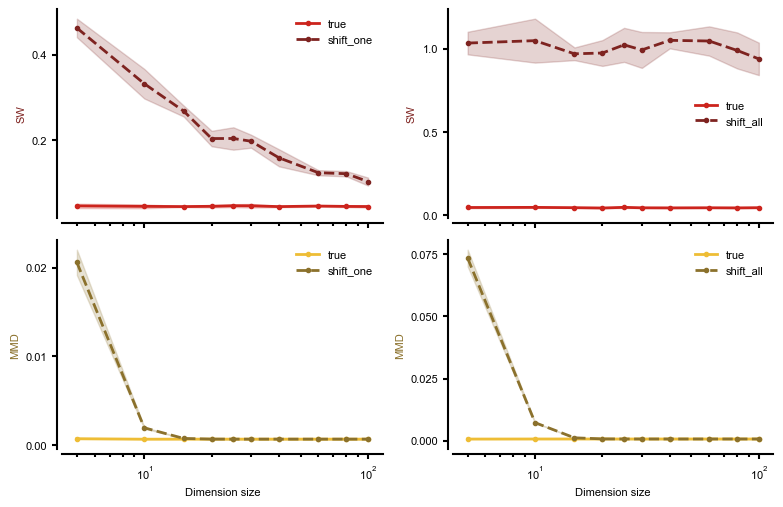

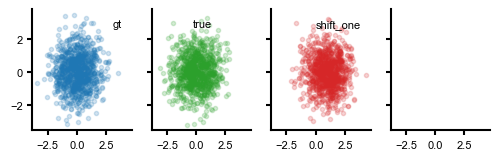

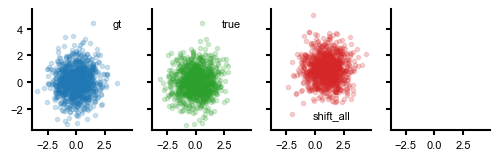

In [8]:
print("Running experiments...")
# load the config file
cfg = OmegaConf.load("configs/conf_dims.yaml") 
cfg.running_user = 'scaling_dims'
seed = cfg.seed

set_seed(seed)
print(f"Seed: {seed}")
print(f"Experiments: {cfg.experiments}") 
print(f"Data: {cfg.data}\n")

col_dark = {}
col_light = {}
for e, exp_name in enumerate(cfg.experiments):
    col_dark[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='dark')[2]
    col_light[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='light')[-1]
color_list = [col_light, col_dark] # make this a list to account for true and shifted
 
mapping = {'ScaleDimKL':'KL', 'ScaleDimSW':'SW',
        'ScaleDimMMD':'MMD', 'ScaleDimC2ST':'C2ST',
        'ScaleDimFID':'FD', }

# assert cfg.data is list
assert len(cfg.data) == len(cfg.n) == len(cfg.d), "Data, n and d must be lists of the same length"
    
dataset_fn = get_dataset(name=cfg.data[0])

# make comparison plots
fig, axes = plt.subplots(len(cfg.experiments), len(cfg.distort), figsize=cm2inch((20, 13)), sharex='col')
for ax in axes.flatten():
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=4)

# Base datasets
dataset_gt = dataset_fn(cfg.n[0]*cfg.runs, cfg.d[0], distort=None)
dataset_intra = dataset_fn(cfg.n[0]*cfg.runs, cfg.d[0], distort=None)
print(f"Dataset shape: {dataset_gt.shape}")
print(f"Dataset shape: {dataset_intra.shape}")

for d, distort in enumerate(cfg.distort):
    print(f"Distort: {distort.upper()}")
    label_true = {}
    label_shift = {}
    for e, data_name in enumerate(cfg.data):
        label_true[data_name] = "true"
        label_shift[data_name] = cfg.distort[d]
    label_list = [label_true, label_shift]

    # Distorted 
    dataset_inter = dataset_fn(cfg.n[0]*cfg.runs, cfg.d[0], distort=cfg.distort[d])

    # Data plots
    fig_data, axes_data = plt.subplots(1, 4, figsize=cm2inch((15, 4)), sharex=True, sharey=True)
    axes_data[0].plot(dataset_gt[:1000, 0], dataset_gt[:1000, 1], 'o', label='gt', alpha=0.2, color='C0')
    axes_data[1].plot(dataset_intra[:1000, 0], dataset_intra[:1000, 1], 'o', label='true',  alpha=0.2, color='C2')
    axes_data[2].plot(dataset_inter[:1000, 0], dataset_inter[:1000, 1], 'o', label=cfg.distort[d] ,alpha=0.2, color='C3')
    for ax in axes_data:
        ax.legend()

    for e, exp_name in enumerate(cfg.experiments):
        experiment = globals()[exp_name]()
        time_start = time.time()
        dataset1 = dataset_gt
        ax = axes[e, d]
        ax.set_xscale('log')
        for dc, data_comp in enumerate([dataset_intra, dataset_inter]):
            dataset2 = data_comp
            assert dataset1.shape == dataset2.shape, f"Dataset shapes do not match: {dataset1.shape} vs. {dataset2.shape}"
            output = experiment.run_experiment(dataset1=dataset1,
                                            dataset2=dataset2,
                                            dataset_size = cfg.n[0], 
                                            dim_sizes=cfg.dim_sizes,
                                            nb_runs = cfg.runs)
            time_end = time.time()
            print(f"Experiment {exp_name} finished in {time_end - time_start}")

            log_path = get_log_path(cfg)
            os.makedirs(os.path.dirname(log_path), exist_ok=True)
            experiment.log_results(output, log_path)
            print(f"Numerical results saved to {log_path}")
            experiment.plot_experiment(*output,
                cfg.data[0],
                ax=ax,
                color=color_list[dc][exp_name],
                label=label_list[dc][cfg.data[0]],
                linestyle='-' if dc == 0 else '--',lw=2, marker='o'
            )
            ax.set_ylabel(mapping[exp_name])
            ax.set_xlabel('')
            if mapping[exp_name]  == 'C2ST':
                ax.set_ylim([0.45,1])
                ax.set_yticks([0.5,1])
            
        ax.legend()

axes[-1, 0].set_xlabel('Dimension size')
axes[-1, 1].set_xlabel('Dimension size')

fig.tight_layout()
print(f"Plots saved to {cfg.data[0]}.png")
fig.savefig(f"./plots/metric_comparison_dim_size_{cfg.data[0]}.png", dpi=300)
fig.savefig(f"./plots/metric_comparison_dim_size_{cfg.data[0]}.pdf", dpi=300)

print("Finished running experiments.")
